# 400 - gradient et backward

On peut avoir un réseau de neurones comme un gros sandwitch avec de multiples couches de neurones dans lequel on a envie d'insérer sa propre couche mais pour cela il faut interférer avec le gradient. J'ai repris le tutoriel [pytorch: defining new autograd functions](https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html). L'exemple suivant [Extending Torch](https://pytorch.org/docs/master/notes/extending.html). J'aimais bien l'API de la version 0.4 mais je ne la trouve plus sur internet. Elle laissait sans doute un peu trop de liberté.

In [1]:
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
print("torch", torch.__version__)
from torchvision import datasets, transforms
from tqdm import tqdm

torch 1.0.1


In [2]:
%matplotlib inline

In [3]:
BATCH_SIZE = 64
TEST_BATCH_SIZE = 64
DATA_DIR = 'data/'
USE_CUDA = False  # switch to True if you have GPU
N_EPOCHS = 2 # 5

In [4]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Couche personnalisée

L'exemple suivant illustre comment définir une couche intermédiaire qui obéit à ses propres règles. Elle doit implémenter les deux méthodes ``forward`` qui calcule la prédiction pour la couche suivante et ``backward`` pour le calcul du gradient pour la couche précédente. Il reste la variable ``ctx`` qui permet de stocker des informations qui persistent jusqu'au calcul du gradient.

In [5]:
class MyReLU(torch.autograd.Function):

    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input < 0] = 0
        return grad_input

## exemple avec MNIST

C'est à ce moment que je choisis pour bifurque sur un autre tutoriel [pytorch et MNIST](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html) qui commence sur un réseau de neurones pour *MNIST* et pas vraiment *MNIST* puisque c'est une régression avec deux sorties.

In [6]:
dtype = torch.float
device = torch.device("cpu")

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)


## Le gradient

On choisit une entrée aléatoire mais aux mêmes dimensions qu'une image et on calcule la sortie du réseau de neurones.

In [8]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[0.0787, 0.0109]], grad_fn=<AddmmBackward>)


Pour calculer le gradient, il faut choisir une erreur... On prend le [MSELoss](https://pytorch.org/docs/stable/nn.html?highlight=mseloss#torch.nn.MSELoss) même si ça n'a rien à voir avec le problème initial mais on s'en fout.

In [9]:
criterion = nn.MSELoss()

On choisit une entrée aléatoire...

In [10]:
target = torch.randn(2)

On calcule une sortie et on redimensionne la cible de sorte qu'elle est la même dimension que la cible.

In [11]:
output = net(input)
target = target.view(1, -1)  # make it the same shape as output
output, target

(tensor([[0.0787, 0.0109]], grad_fn=<AddmmBackward>),
 tensor([[1.3361, 1.0640]]))

Maintenantn on calcule l'erreur de prédiction...

In [12]:
loss = criterion(output, target)
loss

tensor(1.3450, grad_fn=<MseLossBackward>)

Et on calcule enfin le gradient :

In [13]:
loss.backward()

Je m'attendais à trouver le gradient sur la forme d'un beau vecteur mais comme c'est un réseau de neurones, le gradient est stocké dans chacune des couches sous la forme d'un gradient et encore en deux morceaux...

In [14]:
net.conv1.bias.grad

tensor([ 0.0066, -0.0196, -0.0231,  0.0315, -0.0020,  0.0007])

In [15]:
net.conv1.weight.grad

tensor([[[[ 0.0095, -0.0006, -0.0392, -0.0126, -0.0041],
          [-0.0260, -0.0403,  0.0386, -0.0262, -0.0227],
          [-0.0101, -0.0084,  0.0014, -0.0033, -0.0176],
          [ 0.0076, -0.0314, -0.0006,  0.0549, -0.0369],
          [-0.0123, -0.0026,  0.0023,  0.0166, -0.0260]]],


        [[[-0.0343, -0.0081,  0.0352, -0.0274, -0.0183],
          [ 0.0027,  0.0479,  0.0394,  0.0434, -0.0248],
          [-0.0264, -0.0139, -0.0534,  0.0244,  0.0021],
          [-0.0420,  0.0307, -0.0228,  0.0034, -0.0165],
          [ 0.0122,  0.0110, -0.0444, -0.0334,  0.0263]]],


        [[[-0.0141, -0.0519,  0.0308,  0.0218,  0.0136],
          [-0.0326, -0.0011, -0.0127,  0.0012,  0.0404],
          [ 0.0048,  0.0255,  0.0245, -0.0290,  0.0161],
          [-0.0439,  0.0103, -0.0124, -0.0019,  0.0125],
          [ 0.0062, -0.0022,  0.0098,  0.0100, -0.0239]]],


        [[[ 0.0036,  0.0205,  0.0100,  0.0446, -0.0065],
          [-0.0005, -0.0240,  0.0255,  0.0428, -0.0164],
          [-0.0390,

## On change de couche

Non, il n'est pas trois heures du matin et personne ne pleure.

In [16]:
class Net0(nn.Module):

    def __init__(self):
        super(Net0, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = MyReLU(self.fc1(x))
        x = MyReLU(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net0 = Net0()
print(net0)

Net0(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)


Evidemment, ça ne marche jamais du premier coup. On a beaucoup sous-estimé le temps de préparation des cours avec l'informatique. Il est seulement 9h du soir, l'humilité vient seulement après minuit.

In [17]:
try:
    output = net0(input)
except Exception as e:
    print(e)

'MyReLU' object has no attribute 'dim'


J'avoue que j'ai tout lu en diagonal pensant que ma science infinie me permettrait de combler mon ignorance. Honnêtement, il est temps de dîner !

## After the bug...

J'ai craqué, je n'ai pas eu le courage de recoder à 2h du matin trying to figure out what's going wrong. J'ai mélangé tout ce que j'ai pu trouvé et il est quasiment 2h du matin le lendemain.

In [18]:
class MyReLUF(torch.autograd.Function):

    def forward(self, input):
        self.input = input
        res = input.clamp(min=0)
        return res

    def backward(self, grad_output):
        input = self.input
        grad_input = grad_output.clone()
        grad_input[input < 0] = 0
        return grad_input

    
class MyReLUNN(nn.Module):

    def __init__(self):
        super(MyReLUNN, self).__init__()
        self.fct = MyReLUF()

    def forward(self, input):
        return self.fct(input)

    def extra_repr(self):
        return 'in_features={}'.format(self.in_features)
        

class Net2(nn.Module):

    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        self.fct1 = MyReLUNN()
        self.fct2 = MyReLUNN()

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fct1(self.fc1(x))
        x = self.fct2(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    
net2 = Net2()
output = net2(input)
output

tensor([[-0.0018, -0.0584]], grad_fn=<AddmmBackward>)

In [19]:
target = target.view(1, -1)  # make it the same shape as output
output, target

(tensor([[-0.0018, -0.0584]], grad_fn=<AddmmBackward>),
 tensor([[1.3361, 1.0640]]))

In [20]:
loss = criterion(output, target)
loss

tensor(1.5248, grad_fn=<MseLossBackward>)

In [21]:
loss.backward()

In [22]:
net2.conv1.bias.grad

tensor([ 0.0058,  0.0213,  0.0070,  0.0215, -0.0197,  0.0576])

In [23]:
net2.conv1.weight.grad

tensor([[[[ 2.5295e-02,  1.8537e-02,  1.1849e-03, -5.1018e-02,  4.1500e-04],
          [ 2.3580e-02,  2.2555e-03,  1.4027e-02,  1.4610e-02,  1.6759e-02],
          [-3.2709e-02, -2.4234e-02,  2.1113e-02, -9.4233e-03, -3.0967e-02],
          [-1.3462e-02,  1.3543e-02, -1.9096e-02, -1.2949e-04, -1.4310e-02],
          [ 1.3757e-02, -1.9788e-02,  3.2602e-02,  4.2691e-04,  6.7591e-03]]],


        [[[-2.6508e-02, -2.2323e-02, -1.3083e-03,  1.3417e-02, -7.8643e-03],
          [ 1.0785e-02, -1.5043e-02, -2.7794e-02, -6.4861e-03, -4.3250e-02],
          [ 1.6622e-02,  3.3575e-02, -3.2311e-02,  5.9213e-03,  2.5585e-02],
          [ 1.9300e-02,  1.8039e-02,  1.2932e-02, -2.2850e-03, -4.2998e-02],
          [ 7.0336e-03, -2.8465e-02,  2.0368e-02,  3.4303e-02, -1.9628e-02]]],


        [[[-2.8831e-03, -4.1277e-02, -3.8946e-02, -7.9885e-03, -4.9228e-02],
          [-6.0674e-02, -9.1310e-03, -1.4517e-02,  5.7487e-04, -1.2545e-02],
          [ 1.7343e-02, -2.4426e-02, -7.4782e-03, -8.2859e-03,  1.37

## Ca converge ?

Il ne reste plus qu'à voir si cela converge. On crée une cible un peu alambiquée.

In [24]:
N = 10000
inputs = torch.randn(N, 1, 1, 32, 32)
targets = torch.zeros(N, 2)
for i in range(N):
    s1 = inputs[i, :, :, :16, :].sum() / 10
    s2 = inputs[i, :, :, 16:, :].sum() / 10
    targets[i, 0] = s1
    targets[i, 1] = s2

In [25]:
targets[:5]

tensor([[ 0.2842,  2.9707],
        [-0.0656, -1.1306],
        [-1.2251,  0.5147],
        [-3.2201, -2.8353],
        [ 0.5839, -2.4045]])

In [26]:
torch.sum(targets, 0)

tensor([124.1784,  84.6628])

On choisit l'algorithme d'optimisation et la fonction de coût. Rien d'original dans tout ça.

In [27]:
max_iter = 50

In [28]:
from tqdm import tqdm
import random

model = net2
optimizer = torch.optim.SGD(model.parameters(), lr=0.0002)
loss_func = torch.nn.MSELoss()

average_loss = []

for i in tqdm(range(max_iter)):
    
    ave_loss = 0
    nb = 0
    
    optimizer.zero_grad()
    for it in range(inputs.shape[0] // 10):
        h = random.randint(0, inputs.shape[0] - 1)
        x = inputs[h, :, :, :, :]
        y = targets[h, :]
        
        preds = model(x)
        loss = loss_func(preds, y)

        loss.backward()
        
        ave_loss += loss
        nb += 1
        
    optimizer.step()
    ave_loss /= nb
    average_loss.append((i, ave_loss))

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.17s/it]


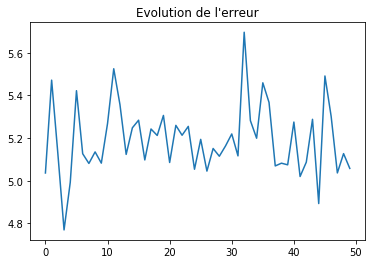

In [29]:
import matplotlib.pyplot as plt
plt.plot([_[0] for _ in average_loss],
         [_[1] for _ in average_loss])
plt.title("Evolution de l'erreur");

## On réessaye avec un réseau plus simple

In [30]:
class Net11(nn.Module):

    def __init__(self):
        super(Net11, self).__init__()
        self.lay1 = nn.Linear(1, 10)
        self.fct1 = MyReLUNN()
        self.lay2 = nn.Linear(10, 1)
        self.fct2 = MyReLUNN()

    def forward(self, x):
        x = self.fct1(self.lay1(x))
        x = self.fct2(self.lay2(x))
        return x

    
net11 = Net11()
input = torch.randn(1, 1)
output = net11(input)
output

tensor([[0.]], grad_fn=<MyReLUF>)

In [31]:
N = 500
inputs = torch.randn(N, 1)
rnd = torch.randn(N, 1)
targets = torch.zeros(N, 1)
for i in range(N):
    y = abs(inputs[i, 0]) + rnd[i, 0] / 5
    targets[i, 0] = y

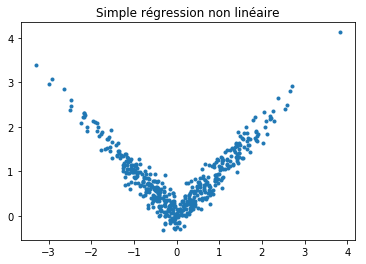

In [32]:
plt.plot(list(inputs[:, 0]), list(targets[:, 0]), '.')
plt.title("Simple régression non linéaire");

In [33]:
max_iter = 50

In [34]:
model = net11
optimizer = torch.optim.SGD(model.parameters(), lr=0.02)
loss_func = torch.nn.MSELoss()

average_loss = []

for i in tqdm(range(max_iter)):
    
    ave_loss = 0
    nb = 0
    
    for it in range(inputs.shape[0] // 10):
        h = random.randint(0, inputs.shape[0] - 1)
        x = inputs[h, :]
        y = targets[h, :]
        
        preds = model(x)

        loss = loss_func(preds, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        ave_loss += loss
        nb += 1
        
    ave_loss /= nb
    average_loss.append((i, ave_loss))

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 35.03it/s]


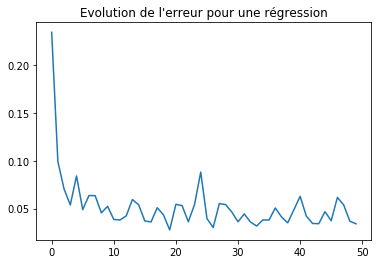

In [35]:
import matplotlib.pyplot as plt
plt.plot([_[0] for _ in average_loss],
         [_[1] for _ in average_loss])
plt.title("Evolution de l'erreur pour une régression");

In [36]:
predictions = model(inputs)

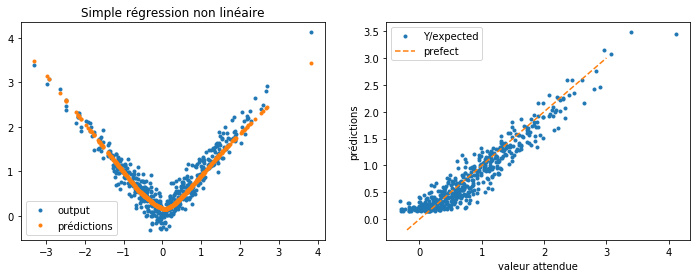

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(list(inputs[:, 0]), list(targets[:, 0]), '.', label="output")
ax[0].plot(list(inputs[:, 0]), list(predictions[:, 0]), '.', label="prédictions")
ax[0].legend()
ax[0].set_title("Simple régression non linéaire")
ax[1].plot(list(targets[:, 0]), list(predictions[:, 0]), '.', label="Y/expected")
ax[1].set_xlabel("valeur attendue")
ax[1].set_ylabel("prédictions")
ax[1].plot([-0.2, 3], [-0.2, 3], '--', label="prefect")
ax[1].legend();

Pas trop mal mais j'ai la flemme d'aller corriger ma première expérience qui n'avait aucun sens de toute façon.